In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from timm import create_model
from itertools import product
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import random
import zipfile
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.files = []
        for idx, cls in enumerate(self.classes):
            cls_dir = os.path.join(root_dir, cls)
            for f in os.listdir(cls_dir):
                if f.endswith('.npy'):
                    self.files.append((os.path.join(cls_dir, f), idx))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        img = np.load(file_path)  # (1, 150, 150), float64, 0-1
        img = torch.tensor(img, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
# The given 150x150 grayscale images (1 channel) needs to become 224x224 RGB (3 channels) properly.
# I had two options, simply duplicating the single channel 3 times or convert in into 3 channels using convolution.
# I have created this class which is a lightweight 1x1 conv layer, it learns a mapping from 1 to 3 channels, preserving info without faking it.
class ChannelAdapter(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 3, kernel_size=1, bias=False)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# Resized the 150 x 150 images into 224 x 224 (supporting VIT inputs)
# Applied Data Augmentation to only training data
# The images are already min-max normalized (0 to 1), slapping on extra normalization would be an overkill - skipped it.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224))
])


In [ ]:
zip_path = "dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


In [ ]:
train_dataset = LensingDataset('/content/dataset/dataset/train', transform=train_transform)
val_dataset = LensingDataset('/content/dataset/dataset/val', transform=val_transform)

In [ ]:
# Initially tried to run a grid search over 36 combos (4 LRs × 3 BSs × 3 DRs), training each for 5 epochs to gauge val loss.
# Due to Time and Computational constrains, switched to Random search over 10 combos (not 36), 3 epochs each (not 5).
learning_rates = [1e-5, 3e-5, 1e-4, 3e-4]
batch_sizes = [16, 32, 64]
drop_rates = [0.0, 0.1, 0.2]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_val_loss = float('inf')
best_params = None
trials = 10

for _ in range(trials):
    lr = random.choice(learning_rates)
    bs = random.choice(batch_sizes)
    dr = random.choice(drop_rates)
    print(f'\nTuning: LR={lr}, BS={bs}, DR={dr}')
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)

    adapter = ChannelAdapter().to(device)
    model = create_model('vit_small_patch16_224', pretrained=True, num_classes=3, drop_rate=dr).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(list(adapter.parameters()) + list(model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)

    for epoch in range(3):
        model.train()
        train_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = adapter(imgs)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                imgs = adapter(imgs)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f'Epoch {epoch+1}/3, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = (lr, bs, dr)

print(f'\nBest Params: LR={best_params[0]}, BS={best_params[1]}, DR={best_params[2]}, Val Loss={best_val_loss:.4f}')


Tuning: LR=0.0003, BS=16, DR=0.0
Epoch 1/3, Train Loss: 1.1087, Val Loss: 1.1007
Epoch 2/3, Train Loss: 1.1003, Val Loss: 1.1009
Epoch 3/3, Train Loss: 1.0992, Val Loss: 1.0987

Tuning: LR=3e-05, BS=32, DR=0.0
Epoch 1/3, Train Loss: 1.0806, Val Loss: 0.9764
Epoch 2/3, Train Loss: 0.8746, Val Loss: 0.7342
Epoch 3/3, Train Loss: 0.6627, Val Loss: 0.5876

Tuning: LR=3e-05, BS=16, DR=0.0
Epoch 1/3, Train Loss: 1.1060, Val Loss: 1.0993
Epoch 2/3, Train Loss: 1.1014, Val Loss: 1.0991
Epoch 3/3, Train Loss: 1.0620, Val Loss: 0.9849

Tuning: LR=0.0001, BS=64, DR=0.1
Epoch 1/3, Train Loss: 1.1088, Val Loss: 1.0999
Epoch 2/3, Train Loss: 1.1030, Val Loss: 1.0988
Epoch 3/3, Train Loss: 1.1010, Val Loss: 1.0991

Tuning: LR=0.0003, BS=16, DR=0.2
Epoch 1/3, Train Loss: 1.1105, Val Loss: 1.0989
Epoch 2/3, Train Loss: 1.1008, Val Loss: 1.0988
Epoch 3/3, Train Loss: 1.0992, Val Loss: 1.0988

Tuning: LR=3e-05, BS=64, DR=0.1
Epoch 1/3, Train Loss: 1.1060, Val Loss: 1.1005
Epoch 2/3, Train Loss: 1.1018, 

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=best_params[1], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_params[1], shuffle=False, num_workers=4)
adapter = ChannelAdapter().to(device)
model = create_model('vit_small_patch16_224', pretrained=True, num_classes=3, drop_rate=best_params[2]).to(device)
optimizer = torch.optim.AdamW(list(adapter.parameters()) + list(model.parameters()), lr=best_params[0])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [ ]:
for epoch in range(15):
    model.train()
    train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        imgs = adapter(imgs)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = adapter(imgs)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.softmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    val_loss /= len(val_loader)

    print(f'Final Epoch {epoch+1}/15, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    scheduler.step()

Final Epoch 1/15, Train Loss: 0.9806, Val Loss: 0.8145
Final Epoch 2/15, Train Loss: 0.7624, Val Loss: 0.7100
Final Epoch 3/15, Train Loss: 0.6530, Val Loss: 0.5625
Final Epoch 4/15, Train Loss: 0.5826, Val Loss: 0.5495
Final Epoch 5/15, Train Loss: 0.5217, Val Loss: 0.4699
Final Epoch 6/15, Train Loss: 0.4826, Val Loss: 0.4932
Final Epoch 7/15, Train Loss: 0.4449, Val Loss: 0.4355
Final Epoch 8/15, Train Loss: 0.4158, Val Loss: 0.3669
Final Epoch 9/15, Train Loss: 0.3864, Val Loss: 0.3701
Final Epoch 10/15, Train Loss: 0.3616, Val Loss: 0.3191
Final Epoch 11/15, Train Loss: 0.3368, Val Loss: 0.3182
Final Epoch 12/15, Train Loss: 0.3229, Val Loss: 0.3166
Final Epoch 13/15, Train Loss: 0.3085, Val Loss: 0.2900
Final Epoch 14/15, Train Loss: 0.2986, Val Loss: 0.2861
Final Epoch 15/15, Train Loss: 0.2978, Val Loss: 0.2895


In [ ]:
torch.save({
    'adapter_state_dict': adapter.state_dict(),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_params': best_params
}, 'vit_lensing_model.pth')
print("Model saved as 'vit_model_common_test.pth'")

Model saved as 'vit_model_common_test.pth'


In [ ]:
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
class_names = ['no', 'sphere', 'vort']

In [ ]:
auc_scores = [roc_auc_score(all_labels == i, all_preds[:, i]) for i in range(3)]
print(f'AUC Scores: {class_names[0]}={auc_scores[0]:.3f}, {class_names[1]}={auc_scores[1]:.3f}, {class_names[2]}={auc_scores[2]:.3f}, Overall={np.mean(auc_scores):.3f}')

AUC Scores: no=0.985, sphere=0.964, vort=0.981, Overall=0.977


In [ ]:
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_scores[i]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.savefig('roc_curves.png')
plt.close()
plt.show()

In [ ]:
cm = confusion_matrix(all_labels, all_preds.argmax(axis=1))
print('Confusion Matrix:')
print(cm)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black' if cm[i, j] < cm.max() / 2 else 'white')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()
plt.show()

Confusion Matrix:
[[2486   12    2]
 [ 342 1968  190]
 [ 166  122 2212]]


In [ ]:
print("Plots saved as 'roc_curves.png' and 'confusion_matrix.png'")

Plots saved as 'roc_curves.png' and 'confusion_matrix.png'


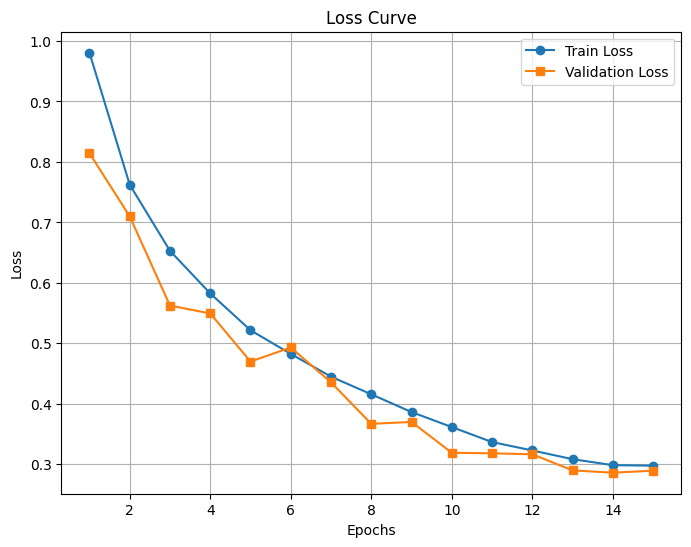

In [2]:
import matplotlib.pyplot as plt
train_losses = [0.9806, 0.7624, 0.6530, 0.5826, 0.5217, 0.4826, 0.4449, 0.4158, 0.3864, 0.3616, 0.3368, 0.3229, 0.3085, 0.2986, 0.2978]
val_losses = [0.8145, 0.7100, 0.5625, 0.5495, 0.4699, 0.4932, 0.4355, 0.3669, 0.3701, 0.3191, 0.3182, 0.3166, 0.2900, 0.2861, 0.2895]
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, 16), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.grid(True)
plt.savefig("loss_curve.png", dpi=300)